### 1. Importing Libraries


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_intermediate_values

from collections import Counter
import warnings
import logging


#### Explanation
-- pandas & numpy: For data manipulation and numerical operations.

-- seaborn & matplotlib: For data visualization.

-- sklearn: A comprehensive machine learning library for model building and evaluation.

-- optuna: For hyperparameter optimization.

-- collections.Counter: To count class distributions.

-- warnings & logging: To handle and log messages and errors.

### 2. Setting Up Logging and Suppressing Warnings


In [40]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

warnings.filterwarnings('ignore')


#### Explanation:
Logging: Helps in tracking the execution flow and debugging.
Suppressing Warnings: Keeps the output clean by hiding non-critical warnings.

### 3. Loading the Data


In [41]:

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


### 4. Defining Features and Target Variable


In [42]:
X = train_data.drop(columns=['id', 'smoking'])
y = train_data['smoking']


In [43]:
train_data.head()


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,...,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,...,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,...,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,...,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


In [44]:
train_data.describe()


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,42.659667,164.669333,64.235333,80.251100,1.034373,1.029453,1.005600,1.00600,119.219133,...,57.374733,113.391200,14.505213,1.016067,0.866873,22.236600,20.859400,26.289933,0.145733,0.369133
std,4330.271354,10.514524,8.524211,10.999092,7.927326,0.304866,0.302373,0.074626,0.07723,11.151900,...,11.436670,18.574279,1.398364,0.160656,0.165501,5.640184,10.310916,18.685708,0.352850,0.482586
min,0.000000,20.000000,140.000000,40.000000,1.000000,0.100000,0.100000,1.000000,1.00000,84.000000,...,28.000000,47.000000,7.300000,1.000000,0.100000,10.000000,5.000000,6.000000,0.000000,0.000000
25%,3749.750000,40.000000,160.000000,55.000000,75.000000,0.900000,0.800000,1.000000,1.00000,110.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,7499.500000,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.00000,119.000000,...,56.000000,113.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,11249.250000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.00000,128.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,14999.000000,85.000000,190.000000,120.000000,117.000000,9.900000,9.900000,2.000000,2.00000,199.000000,...,107.000000,202.000000,18.800000,5.000000,1.500000,87.000000,166.000000,439.000000,1.000000,1.000000


In [45]:
train_data.isnull().sum()


id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

### 5. Identifying Numerical and Categorical Columns


In [46]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
logger.info(f"Numerical columns: {numerical_cols}")
logger.info(f"Categorical columns: {categorical_cols}")


2024-10-28 17:31:43,775 [INFO] Numerical columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
2024-10-28 17:31:43,775 [INFO] Categorical columns: []


#### Explanation:
select_dtypes: Selects columns based on their data type.
numerical_cols: Columns with numerical data types.
categorical_cols: Columns with object/string data types.

### 6. Data Preprocessing


In [47]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


#### Explanation:
Pipeline: Chains multiple preprocessing steps.

SimpleImputer: Handles missing values.

Numerical data: Imputed with the median.

Categorical data: Imputed with the most frequent value (mode).

StandardScaler: Scales numerical features to have mean=0 and variance=1.

OneHotEncoder: Converts categorical variables into a binary matrix.

ColumnTransformer: Applies different preprocessing pipelines to different columns.

### 7. Handling Class Imbalance


In [48]:

counter = Counter(y)
scale_pos_weight = counter[0] / counter[1]
logger.info(f"Class distribution: {counter}")
logger.info(f"Scale_pos_weight: {scale_pos_weight:.2f}")


2024-10-28 17:31:43,811 [INFO] Class distribution: Counter({0.0: 9463, 1.0: 5537})
2024-10-28 17:31:43,817 [INFO] Scale_pos_weight: 1.71


#### Explanation:
Counter: Counts the number of instances in each class.
scale_pos_weight: Helps in balancing classes during model training by scaling the weight of the positive class.

### 8. Splitting the Data


In [49]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y
)


#### Explanation:
train_test_split: Splits the data into training and validation sets.

test_size=0.2: 20% of the data is used for validation.

stratify=y: Ensures the same class distribution in both sets.

random_state: Ensures reproducibility.

### 9. Hyperparameter Optimization with Optuna


In [50]:
def objective(trial):
    try:
        param = {
            'classifier__n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'classifier__max_depth': trial.suggest_int('max_depth', 5, 50),
            'classifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'classifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'classifier__max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'classifier__bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'classifier__criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
        }
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                random_state=101,
                class_weight='balanced',
                n_jobs=-1
            ))
        ])
        
        pipeline.set_params(**param)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
        
        roc_auc_scores = []
        
        for train_idx, test_idx in skf.split(X_train, y_train):
            X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
            
            pipeline.fit(X_tr, y_tr)
            
            y_pred_prob = pipeline.predict_proba(X_te)[:, 1]
            
            score = roc_auc_score(y_te, y_pred_prob)
            roc_auc_scores.append(score)
        
        return np.mean(roc_auc_scores)
    
    except Exception as e:
        logger.error(f"An error occurred during trial: {e}", exc_info=True)
        return float('nan')  


#### Explanation:
objective: A function that Optuna will optimize.

Hyperparameter Search Space: Defines the range of values for each hyperparameter.

Pipeline: Combines preprocessing and the classifier.

StratifiedKFold: Ensures each fold has the same class distribution.

ROC AUC: The metric used for optimization.


### 10. Running the Optuna Study


In [51]:
sampler = TPESampler(seed=101)
study = optuna.create_study(direction='maximize', sampler=sampler)
logger.info("Starting hyperparameter optimization with Optuna...")
study.optimize(objective, n_trials=50) 

logger.info(f"Number of finished trials: {len(study.trials)}")
logger.info("Best trial:")
trial = study.best_trial

logger.info(f"  Value (Average ROC-AUC): {trial.value:.4f}")
logger.info("  Params:")
for key, value in trial.params.items():
    logger.info(f"    {key}: {value}")


[I 2024-10-28 17:31:43,872] A new study created in memory with name: no-name-accdedae-8fd6-4b2c-acd6-30aa6000d2af
2024-10-28 17:31:43,872 [INFO] Starting hyperparameter optimization with Optuna...
[I 2024-10-28 17:31:54,681] Trial 0 finished with value: 0.883237861225999 and parameters: {'n_estimators': 565, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.883237861225999.
[I 2024-10-28 17:32:10,545] Trial 1 finished with value: 0.8784418415331995 and parameters: {'n_estimators': 417, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.883237861225999.
[I 2024-10-28 17:32:18,477] Trial 2 finished with value: 0.8460803754871762 and parameters: {'n_estimators': 143, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False, 

#### Explanation:
TPESampler: A sampler that uses Tree-structured Parzen Estimator for efficient hyperparameter optimization.
create_study: Initializes the Optuna study with the objective to maximize ROC AUC.
study.optimize: Runs the optimization process.
n_trials: Number of hyperparameter combinations to try.
timeout: Maximum time (in seconds) for the optimization.

### 10.1. Visualizing Optuna's Optimization Process


In [52]:

fig1 = plot_optimization_history(study)
fig1.show()

fig2 = plot_param_importances(study)
fig2.show()




#### Explanation
plot_optimization_history: Shows the progression of the objective value over trials.

plot_param_importances: Displays which hyperparameters are most influential in the optimization.

plot_intermediate_values: Useful if the objective function reports intermediate results.

### 11. Building the Final Model with Best Hyperparameters


In [53]:
best_params = trial.params

if not all(key.startswith('classifier__') for key in best_params.keys()):
    best_params_prefixed = {f"classifier__{key}": value for key, value in best_params.items()}
else:
    best_params_prefixed = best_params

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=101,
        class_weight='balanced',
        n_jobs=-1
    ))
])

final_pipeline.set_params(**best_params_prefixed)
logger.info("Best hyperparameters set on the final pipeline.")


2024-10-28 17:54:19,662 [INFO] Best hyperparameters set on the final pipeline.


#### Explanation:
best_params: The optimal hyperparameters found by Optuna.

Pipeline: Recreated with the best hyperparameters.

classifier__ Prefix: Necessary for setting parameters within the pipeline's classifier.

### 12. Training the Final Model


In [54]:
final_pipeline.fit(X_train, y_train)
logger.info("Final model trained on the training set.")


2024-10-28 17:54:23,081 [INFO] Final model trained on the training set.


#### Explanation
fit: Trains the model on the training data.

### 13. Evaluating the Model



In [55]:
y_val_pred = final_pipeline.predict(X_val)
y_val_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]
logger.info("Predictions made on the validation set.")

roc_auc = roc_auc_score(y_val, y_val_pred_prob)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

logger.info(f"Validation ROC-AUC: {roc_auc:.3f}")
logger.info(f"Validation Accuracy: {accuracy:.3f}")
logger.info(f"Validation Precision: {precision:.3f}")
logger.info(f"Validation F1-Score: {f1:.3f}")


2024-10-28 17:54:23,444 [INFO] Predictions made on the validation set.
2024-10-28 17:54:23,444 [INFO] Validation ROC-AUC: 0.894
2024-10-28 17:54:23,444 [INFO] Validation Accuracy: 0.807
2024-10-28 17:54:23,444 [INFO] Validation Precision: 0.697
2024-10-28 17:54:23,444 [INFO] Validation F1-Score: 0.764


#### Explanation
predict: Generates class predictions.

predict_proba: Generates probability estimates.

Metrics:

    ROC-AUC: Measures the ability of the model to distinguish between classes.
    Accuracy: Proportion of correct predictions.
    Precision: Proportion of positive identifications that were actually correct.
    F1-Score: Harmonic mean of precision and recall.

### 13.1 ROC Curve


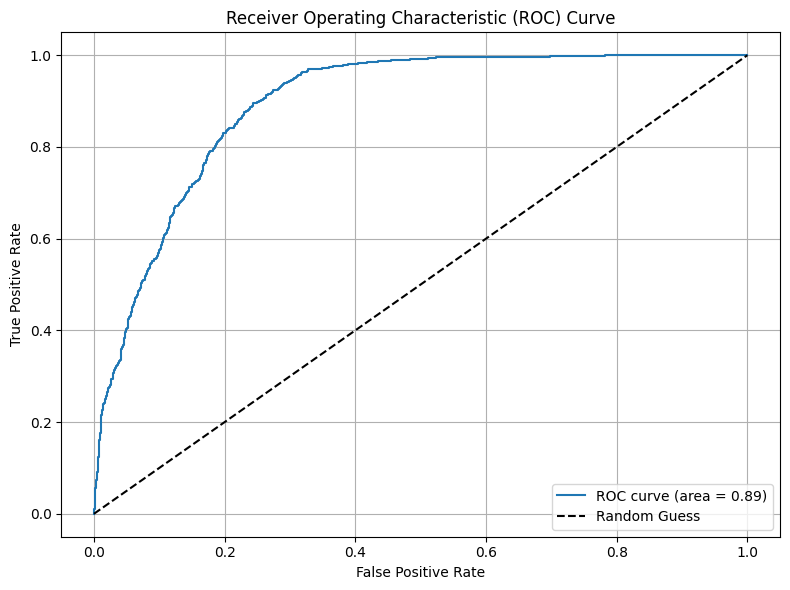

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Explanation
fpr & tpr: False positive rate and true positive rate at various thresholds.

ROC Curve: Plots TPR vs. FPR.

Diagonal Line: Represents random guessing.

Interpretation: The area under the ROC curve (AUC) indicates model performance.

### 13.2 Confusion Matrix


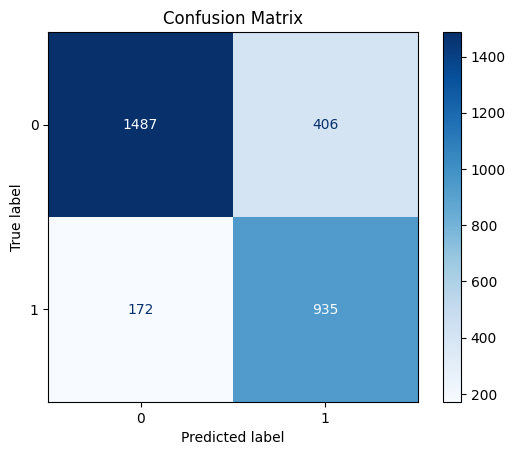

In [57]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


#### Explanation
Confusion Matrix: Shows the number of true positives, true negatives, false positives, and false negatives.

Visualization: Helps in understanding where the model is making mistakes.
Confusion Matrix Example:

### 13.3 Learning Curves


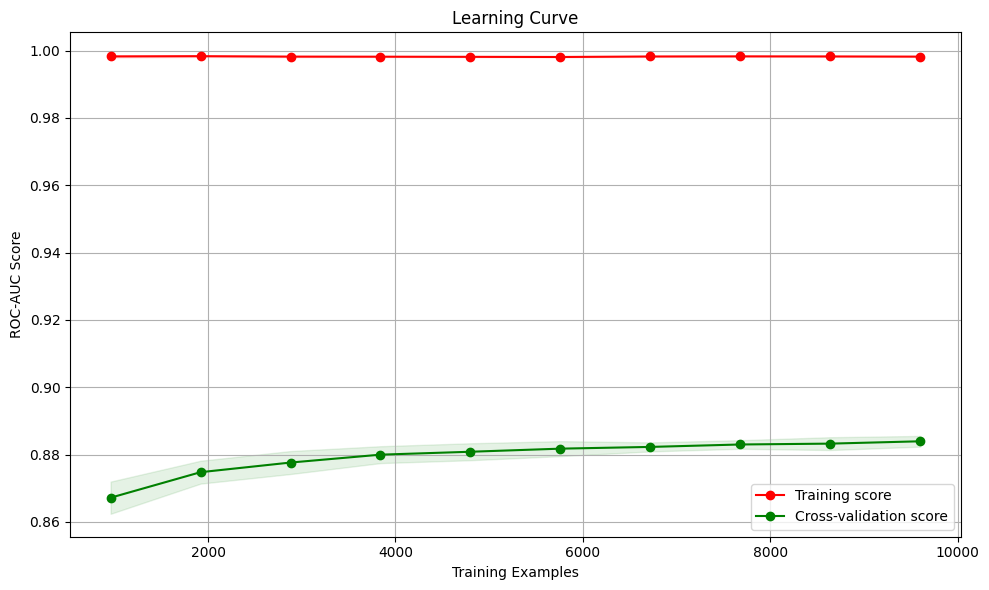

In [58]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, scoring, train_sizes):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1, random_state=101
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("ROC-AUC Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(
    final_pipeline,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=101),
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10)
)


#### Explanation
learning_curve: Computes training and validation scores for different training set sizes.

Plot: Shows how the model's performance improves with more data.

Interpretation:

    High Training Score & Low Validation Score: Indicates overfitting.
    Low Training Score & Low Validation Score: Indicates underfitting.
    Both Scores High & Converging: Indicates good fit.

### 14. Feature Importance


In [59]:
def get_feature_names(preprocessor):
    num_features = numerical_cols
    
    cat_pipeline = preprocessor.named_transformers_['cat']
    onehot = cat_pipeline.named_steps['onehot']
    cat_features = onehot.get_feature_names_out(categorical_cols)
    
    return np.concatenate([num_features, cat_features])

try:
    feature_names = get_feature_names(preprocessor)
    importances = final_pipeline.named_steps['classifier'].feature_importances_
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    logger.info("Top 20 Feature Importances:")
    display(feature_importances_df.head(20))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
except AttributeError as e:
    logger.error("Error in extracting feature names: ", exc_info=True)


2024-10-28 17:55:39,132 [ERROR] Error in extracting feature names: 
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp\ipykernel_7904\1263441652.py", line 11, in <module>
    feature_names = get_feature_names(preprocessor)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_7904\1263441652.py", line 6, in get_feature_names
    cat_features = onehot.get_feature_names_out(categorical_cols)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py", line 1207, in get_feature_names_out
    check_is_fitted(self)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1661, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This OneHotEncoder instance is not fitted yet.

#### Explanation
Feature Importances: Measures how much each feature contributes to the model's predictions.

Visualization: Bar plot of the top 20 most important features.

### 15. Retraining on the Entire Training Data


In [60]:
final_pipeline.fit(X, y)
logger.info("Final model retrained on the entire training dataset.")


2024-10-28 17:55:43,087 [INFO] Final model retrained on the entire training dataset.


#### Explanation
fit: Trains the model on all available training data to maximize its learning before making predictions on unseen data.

### 16. Preparing the Test Dataset


In [61]:
X_test = test_data.drop(columns=['id'])
logger.info("Test dataset prepared.")


2024-10-28 17:55:43,097 [INFO] Test dataset prepared.


#### Explanation
Dropping Columns: Removes the id column as it's not needed for prediction.

### 17. Making Predictions on Test Data


In [62]:
y_test_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
logger.info("Predictions made on the test set.")


2024-10-28 17:55:43,360 [INFO] Predictions made on the test set.


#### Explanation
predict_proba: Generates probability estimates for each class.

[:, 1]: Selects the probability of the positive class (smoking).


### 17.1 Applying Custom Rounding Rules (Optional)


In [63]:

def custom_round(prob):
    if prob > 0.85:
        return 1.0
    elif 0.35 < prob < 0.5:
        return 0.5
    else:
        return round(prob, 2)

y_test_pred_prob_rounded = pd.Series(y_test_pred_prob).apply(custom_round)


#### Explanation
Custom Rounding: Adjusts probability values based on specific thresholds.

Probabilities > 0.85 are set to 1.0.

Probabilities between 0.35 and 0.5 are set to 0.5.

Others are rounded to two decimal places.

### 18. Creating the Submission File


In [64]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'smoking': y_test_pred_prob_rounded  # Use y_test_pred_prob if not applying custom rounding
})

# assert submission.isnull().sum().sum() == 0, "Submission contains missing values."
# assert set(submission.columns) == {'id', 'smoking'}, "Submission columns mismatch."

submission.head()


,id,smoking
0,15000,0.81
1,15001,0.01
2,15002,0.02
3,15003,0.04
4,15004,0.52


#### Explanation
DataFrame: Contains id and the predicted smoking probabilities.

Assertions: Ensure there are no missing values and the correct columns are present.

### 19. Saving the Submission File


In [65]:
submission.to_csv('submission_smoking_random_forest_optuna11.csv', index=False)
logger.info("Submission file saved as 'submission_smoking_random_forest_optuna11.csv'")


2024-10-28 17:55:43,453 [INFO] Submission file saved as 'submission_smoking_random_forest_optuna11.csv'


### 20.Conclusion
In this notebook, we've built a complete machine learning pipeline to predict smoking status using a Random Forest Classifier. We've covered data loading, exploratory data analysis (EDA), preprocessing, handling class imbalance, hyperparameter optimization with Optuna, model evaluation, and preparing submission files. Additionally, we've visualized model performance and feature importances to gain insights into the model's behavior.

Key Takeaways:

    Preprocessing: Proper data preprocessing is crucial for model performance.
    
    Hyperparameter Optimization: Tools like Optuna can significantly enhance model performance by finding optimal hyperparameters.
    
    Model Evaluation: Using multiple metrics and visualizations provides a comprehensive understanding of model performance.

    Feature Importance: Understanding which features influence the model helps in feature selection and gaining domain insights.

This workflow serves as a versatile template for various classification problems and can be adapted to suit different datasets and objectives.

### Additional Notes

Reproducibility: Setting random states ensures that results are reproducible.

Scalability: Pipelines and transformers make the workflow scalable and maintainable.

Visualization: Always visualize results to interpret and validate your models effectively.